In [1]:
import sys
from pathlib import Path
from tqdm import tqdm
import torch
import torchvision as tv

from lvae import get_model

In [2]:
img_dir = Path('d:/datasets/improcessing/kodak')
fig_save_path = '../../runs/bits_distribution.pdf'

def get_kl_distribution(model: torch.nn.Module):
    device = next(model.parameters()).device
    img_paths = list(img_dir.rglob('*.*'))
    bpps_all = None
    for impath in img_paths:
        im = tv.io.read_image(str(impath)).unsqueeze_(0).float().div_(255.0).to(device=device)
        _ = model(im)
        bpps = torch.Tensor(model._stats_log[f'eval_bppix'])
        bpps_all = bpps if (bpps_all is None) else (bpps_all + bpps)
    # print(bpps_all)
    bpps_all = bpps_all / bpps_all.sum()
    return bpps_all


In [3]:
model = qres34m()
model = model.cuda()
model.eval()

lambdas = [16, 64, 128, 256, 512, 1024, 2048]
stats_all = []
for lmb in tqdm(lambdas):
    wpath = pwd / f'../checkpoints/qres34m/lmb{lmb}/last_ema.pt'

    msd = torch.load(wpath)['model']
    out = model.load_state_dict(msd, strict=True)
    bpps = get_kl_distribution(model)
    # stat = [f'lmb={lmb}'] + bpps.tolist()
    stats_all.append(bpps)
stats_all = torch.stack(stats_all, dim=0)

100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


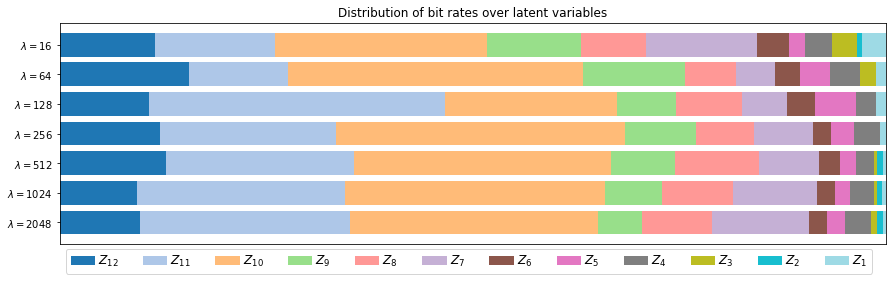

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data = stats_all.numpy()
data = np.flip(data, axis=1) # change the order to z12 -> z1
data_cum = data.cumsum(axis=1)
# category_colors = plt.get_cmap('Set3')
category_colors = plt.get_cmap('tab20')
category_colors = category_colors(np.linspace(0, 1, data.shape[1]))

fig, ax = plt.subplots(figsize=(13.4, 4))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

labels         = [f'$\lambda = {lmb}$' for lmb in lambdas]
category_names = [f'$Z_{{ {i} }}$'     for i   in range(12, 0, -1)]
for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.8,
                    label=colname, color=color)

    # r, g, b, _ = color
    # text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    # ax.bar_label(rects, label_type='center', color=text_color)
ax.legend(ncol=len(category_names), loc='lower left', fontsize=12.2,
          bbox_to_anchor=(0, -0.16), handletextpad=0.24)
ax.set_title('Distribution of bit rates over latent variables')
fig.tight_layout()
fig.savefig(fig_save_path)